In [1]:
# Подключение библиотек

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Input, GlobalAvgPool2D, GlobalMaxPool2D, concatenate
from tensorflow.keras.optimizers import Adam
from IPython.display import Audio
import wave
from joblib import Parallel, delayed
import librosa
from functools import partial
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загрузка данных

train = pd.read_csv('train.csv')
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [3]:
file = '0b82b3a5.wav'
path = 'C:\\Users\\user\\OneDrive - Ltd.E-Promo\\Desktop\\Анализ звука и голоса\\audio_train\\'
Audio(filename=path+file)

In [4]:
# Нахождение длительности аудиофайлов и запись в датафрейм

def get_duration(file):
    return wave.open(path+file).getnframes()/wave.open(path+file).getframerate()

with Parallel(n_jobs=10, prefer='threads', verbose=0) as ex:
    durations = ex(delayed(get_duration)(e) for e in train['fname'])
    
train['duration'] = durations
train.head()

,fname,label,manually_verified,duration
0,00044347.wav,Hi-hat,0,14.00
1,001ca53d.wav,Saxophone,1,10.32
2,002d256b.wav,Trumpet,0,0.44
3,0033e230.wav,Glockenspiel,1,8.00
4,00353774.wav,Cello,1,4.52


In [5]:
# Выбирание  аудифайлов, длительность которых не превышает 3 сеунды

train = train.loc[train['duration'] <= 3]
train.head()

,fname,label,manually_verified,duration
2,002d256b.wav,Trumpet,0,0.44
6,003da8e5.wav,Knock,1,1.36
7,0048fd00.wav,Gunshot_or_gunfire,1,1.04
10,006f2f32.wav,Hi-hat,1,1.68
12,00780200.wav,Snare_drum,0,1.12


librosa вычислила 40 MFCC на 95 -кадровом аудиосемпле


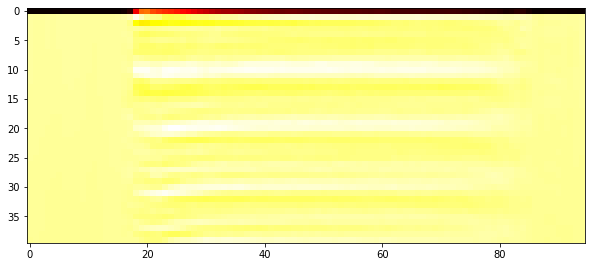

In [6]:
# Извлечение MFCC из аудио с использованием Librosa

y, sr = librosa.load(path+file)
mfcc = librosa.feature.mfcc(y, sr, n_mfcc=40)
print("librosa вычислила", mfcc.shape[0], "MFCC на", mfcc.shape[1], "-кадровом аудиосемпле")
plt.figure(figsize=(10,5))
plt.imshow(mfcc, cmap='hot');

In [7]:
# Извлечение функций
def obtain_mfcc(file, features=40):
    y, sr = librosa.load(path+file, res_type='kaiser_fast')
    return librosa.feature.mfcc(y, sr, n_mfcc=features)

In [8]:
obtain_mfcc(file).shape

(40, 95)

In [9]:
mfcc.shape

(40, 95)

(40, 100)


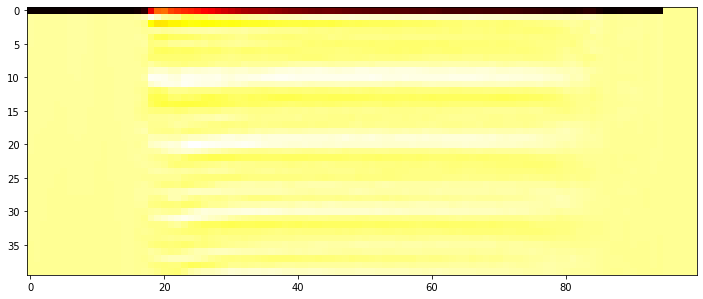

In [10]:
def get_mfcc(file, n_mfcc=40, padding=None):
    y, sr = librosa.load(path+file, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y, sr, n_mfcc=n_mfcc)
    if padding: mfcc = np.pad(mfcc, ((0, 0), (0, max(0, padding-mfcc.shape[1]))), 'constant')
    return mfcc.astype(np.float32)

mfcc = get_mfcc(file, padding=100)
print(mfcc.shape)
plt.figure(figsize=(12,5))
plt.imshow(mfcc, cmap='hot');

In [11]:
# Нахождение padding для самого продолжительного файла
print(get_mfcc(train.sort_values('duration').fname.iloc[-1]).shape)

(40, 130)


In [12]:
# Преобразование данных для обучения

n_mfcc = 40
padding = 130
fun = partial(get_mfcc, n_mfcc=n_mfcc, padding=padding)

with Parallel(n_jobs=10, prefer='threads', verbose=0) as ex:
    mfcc_data = ex(delayed(partial(fun))(e) for e in train['fname'])
    
mfcc_data = np.stack(mfcc_data)[..., None]
mfcc_data.shape

(3936, 40, 130, 1)

In [13]:
mfcc_data

array([[[[-4.82412628e+02],
         [-4.07738037e+02],
         [-3.85441376e+02],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 9.47219391e+01],
         [ 9.75328064e+01],
         [ 1.02200790e+02],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[-8.50574493e+01],
         [-4.64571190e+01],
         [-2.51263943e+01],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        ...,

        [[ 1.11257315e-01],
         [ 2.60601807e+00],
         [ 1.52873838e+00],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[-4.13889551e+00],
         [-9.32245827e+00],
         [-1.47865658e+01],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[-5.27465439e+00],
         [-4.16694641e+00],
         [

In [14]:
label_unique = list(train['label'].unique())
label_number = {label: i for i, label in enumerate(label_unique)}
train["label_number"] = train.label.map(label_number)

In [15]:
train.head()

,fname,label,manually_verified,duration,label_number
2,002d256b.wav,Trumpet,0,0.44,0
6,003da8e5.wav,Knock,1,1.36,1
7,0048fd00.wav,Gunshot_or_gunfire,1,1.04,2
10,006f2f32.wav,Hi-hat,1,1.68,3
12,00780200.wav,Snare_drum,0,1.12,4


In [18]:
# Разделение данных на обучающие и тестовые

x_train, x_val, y_train, y_val = train_test_split(mfcc_data, train['label_number'], test_size=0.2, random_state=42)
x_train.shape, x_val.shape

((3148, 40, 130, 1), (788, 40, 130, 1))

In [19]:
# Архитектура модели

m_in = Input([n_mfcc, padding, 1])
x = BatchNormalization()(m_in)

x = Conv2D(10, 3, strides=1, activation='relu', padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)

x = Conv2D(20, 3, strides=(2,2), activation='relu', padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)

x = Conv2D(50, 3, strides=(2,2), activation='relu', padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)

x = Conv2D(100, 3, strides=(2,2), activation='relu', padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)
    
x_avg = GlobalAvgPool2D()(x)
x_max = GlobalMaxPool2D()(x)

x = concatenate([x_avg, x_max])
x = Dense(1000, activation='relu', use_bias=False, kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
m_out = Dense(len(label_unique), activation='softmax')(x)

model_1 = Model(m_in, m_out)
model_1.compile(Adam(0.002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 130, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 40, 130, 1)  4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 40, 130, 10)  90          ['batch_normalization[0][0]']    
                                                                                              

In [20]:
score = model_1.evaluate(x_train, y_train, verbose=0)
print("Точность модели перед тренировкой", 100*score[1])

Точность модели перед тренировкой 2.0648030564188957


In [21]:
%%time
# K.eval(model_1.optimizer.lr.assign(0.0003))
model_1.fit(x_train, y_train, 64, 50, validation_data=[x_val, y_val])

Epoch 1/50
50/50 [==============================] - 9s 173ms/step - loss: 3.9735 - accuracy: 0.2640 - val_loss: 3.0260 - val_accuracy: 0.2602
Epoch 2/50
50/50 [==============================] - 10s 202ms/step - loss: 1.9632 - accuracy: 0.4794 - val_loss: 2.8812 - val_accuracy: 0.2221
Epoch 3/50
50/50 [==============================] - 10s 199ms/step - loss: 1.5883 - accuracy: 0.5588 - val_loss: 2.3327 - val_accuracy: 0.3604
Epoch 4/50
50/50 [==============================] - 10s 203ms/step - loss: 1.3681 - accuracy: 0.6188 - val_loss: 1.8057 - val_accuracy: 0.4949
Epoch 5/50
50/50 [==============================] - 11s 219ms/step - loss: 1.1676 - accuracy: 0.6693 - val_loss: 1.5907 - val_accuracy: 0.5635
Epoch 6/50
50/50 [==============================] - 13s 255ms/step - loss: 1.0392 - accuracy: 0.6995 - val_loss: 1.4844 - val_accuracy: 0.5901
Epoch 7/50
50/50 [==============================] - 11s 221ms/step - loss: 0.8721 - accuracy: 0.7408 - val_loss: 1.3052 - val_accuracy: 0.6637


In [22]:
score = model_1.evaluate(x_train, y_train, verbose=0)
print("Точность обучения: {0:.2%}".format(score[1]))
score = model_1.evaluate(x_val, y_val, verbose=0)
print("Точность тестирования: {0:.2%}".format(score[1]))

Точность обучения: 98.86%
Точность тестирования: 71.95%
